## Retrieving all OpenData Toronto data 'Daily Shelter & Overnight Service Occupancy & Capacity'

In [ ]:
# import requests

# base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
# package_id = "daily-shelter-overnight-service-occupancy-capacity"

# # Get package metadata
# package = requests.get(f"{base_url}/api/3/action/package_show", params={"id": package_id}).json()

# # Find the first active resource
# for resource in package["result"]["resources"]:
#     if resource["datastore_active"]:
#         resource_id = resource["id"]
#         csv_url = f"{base_url}/datastore/dump/{resource_id}"
        
#         # Download entire CSV at once
#         csv_text = requests.get(csv_url).text
#         with open("../data/sheltersdata.csv", "a", encoding="utf-8") as f:
#             f.write(csv_text)
#         print("All data saved as data/shelters.csv")
        
import requests

# --- (Your setup code like 'base_url' and 'package') ---

output_file = "../data/sheltersdata.csv"
is_first_file = True # Use a flag to track the first write

print(f"Starting download to {output_file}...")

# Open the file *once* before the loop in write mode
with open(output_file, "w", encoding="utf-8") as f:
    for resource in package["result"]["resources"]:
        if resource["datastore_active"]:
            resource_id = resource["id"]
            csv_url = f"{base_url}/datastore/dump/{resource_id}"
            
            print(f"Downloading data from resource {resource_id}...")
            csv_text = requests.get(csv_url).text

            if is_first_file:
                # 1. For the first file, write the whole thing (headers included)
                f.write(csv_text)
                is_first_file = False # Unset the flag
            else:
                # 2. For all other files, skip their header line
                lines = csv_text.splitlines()
                if len(lines) > 1: # Make sure there's data to write
                    # Write from the second line (index 1) onwards
                    # We add our own newline to ensure separation
                    f.write("\n" + "\n".join(lines[1:]))

print(f"All data saved correctly to {output_file}")

Starting download to ../data/sheltersdata.csv...
All data saved correctly to ../data/sheltersdata.csv


In [15]:
import pandas as pd

# Load CSV
df = pd.read_csv("../data/sheltersdata.csv")

# Convert date
df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'], format='mixed')

# Quick look
print(df.head())
print(df.info())


   _id OCCUPANCY_DATE  ORGANIZATION_ID         ORGANIZATION_NAME  SHELTER_ID  \
0    1     2025-01-01               24  COSTI Immigrant Services          40   
1    2     2025-01-01               24  COSTI Immigrant Services          40   
2    3     2025-01-01               24  COSTI Immigrant Services          40   
3    4     2025-01-01               24  COSTI Immigrant Services          40   
4    5     2025-01-01               24  COSTI Immigrant Services          40   

            SHELTER_GROUP  LOCATION_ID               LOCATION_NAME  \
0  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
1  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
2  COSTI Reception Centre       1051.0      COSTI Reception Centre   
3  COSTI Reception Centre       1051.0      COSTI Reception Centre   
4  COSTI Reception Centre       1114.0  COSTI Uptown Hotel Program   

    LOCATION_ADDRESS LOCATION_POSTAL_CODE  ... OCCUPIED_BEDS UNOCCUPIED_BEDS  \
0      640 Dixon R

## Observations:

OCCUPIED_BEDS, CAPACITY_ACTUAL_BED, CAPACITY_FUNDING_BED → ~33k non-null

CAPACITY_ACTUAL_ROOM, OCCUPIED_ROOMS, OCCUPANCY_RATE_ROOMS → ~11k non-null

LOCATION_ADDRESS, LOCATION_POSTAL_CODE, LOCATION_CITY, LOCATION_PROVINCE → small fraction missing

Some rows only have room-based capacity, others bed-based.

__Beds are a more complete data point so we can focus on this for regression and classification__

In [16]:
# Drop rows missing the regression target
df = df.dropna(subset=['OCCUPIED_BEDS'])

# Classification target
df['overcapacity'] = (df['OCCUPANCY_RATE_BEDS'] > 95).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165802 entries, 2 to 242657
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id                     165802 non-null  int64         
 1   OCCUPANCY_DATE          165802 non-null  datetime64[ns]
 2   ORGANIZATION_ID         165802 non-null  int64         
 3   ORGANIZATION_NAME       165802 non-null  object        
 4   SHELTER_ID              165802 non-null  int64         
 5   SHELTER_GROUP           165664 non-null  object        
 6   LOCATION_ID             165558 non-null  float64       
 7   LOCATION_NAME           164512 non-null  object        
 8   LOCATION_ADDRESS        160855 non-null  object        
 9   LOCATION_POSTAL_CODE    160881 non-null  object        
 10  LOCATION_CITY           160835 non-null  object        
 11  LOCATION_PROVINCE       160455 non-null  object        
 12  PROGRAM_ID              165802 non-

## Feature Engineering

In [17]:
# Temporal Features
df['day_of_week'] = df['OCCUPANCY_DATE'].dt.dayofweek
df['month'] = df['OCCUPANCY_DATE'].dt.month
df['week_of_year'] = df['OCCUPANCY_DATE'].dt.isocalendar().week

In [18]:
# Lag & Rolling Features
df = df.sort_values(['SHELTER_ID','OCCUPANCY_DATE'])
df['lag_1'] = df.groupby('SHELTER_ID')['OCCUPIED_BEDS'].shift(1)
df['lag_7'] = df.groupby('SHELTER_ID')['OCCUPIED_BEDS'].shift(7)
df['roll_mean_7'] = df.groupby('SHELTER_ID')['OCCUPIED_BEDS'].rolling(7).mean().shift(1).reset_index(0, drop=True)

In [19]:
# Encode categorical features as bools
cat_cols = ['SECTOR','PROGRAM_MODEL','OVERNIGHT_SERVICE_TYPE','PROGRAM_AREA']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [20]:
# Handle missing values for lag features:

df.fillna(0, inplace=True)
df.info()
df['day_of_week'].unique()


<class 'pandas.core.frame.DataFrame'>
Index: 165802 entries, 191809 to 45062
Data columns (total 52 columns):
 #   Column                                                   Non-Null Count   Dtype         
---  ------                                                   --------------   -----         
 0   _id                                                      165802 non-null  int64         
 1   OCCUPANCY_DATE                                           165802 non-null  datetime64[ns]
 2   ORGANIZATION_ID                                          165802 non-null  int64         
 3   ORGANIZATION_NAME                                        165802 non-null  object        
 4   SHELTER_ID                                               165802 non-null  int64         
 5   SHELTER_GROUP                                            165802 non-null  object        
 6   LOCATION_ID                                              165802 non-null  float64       
 7   LOCATION_NAME                          

array([6, 0, 2, 3, 5, 1, 4], dtype=int32)

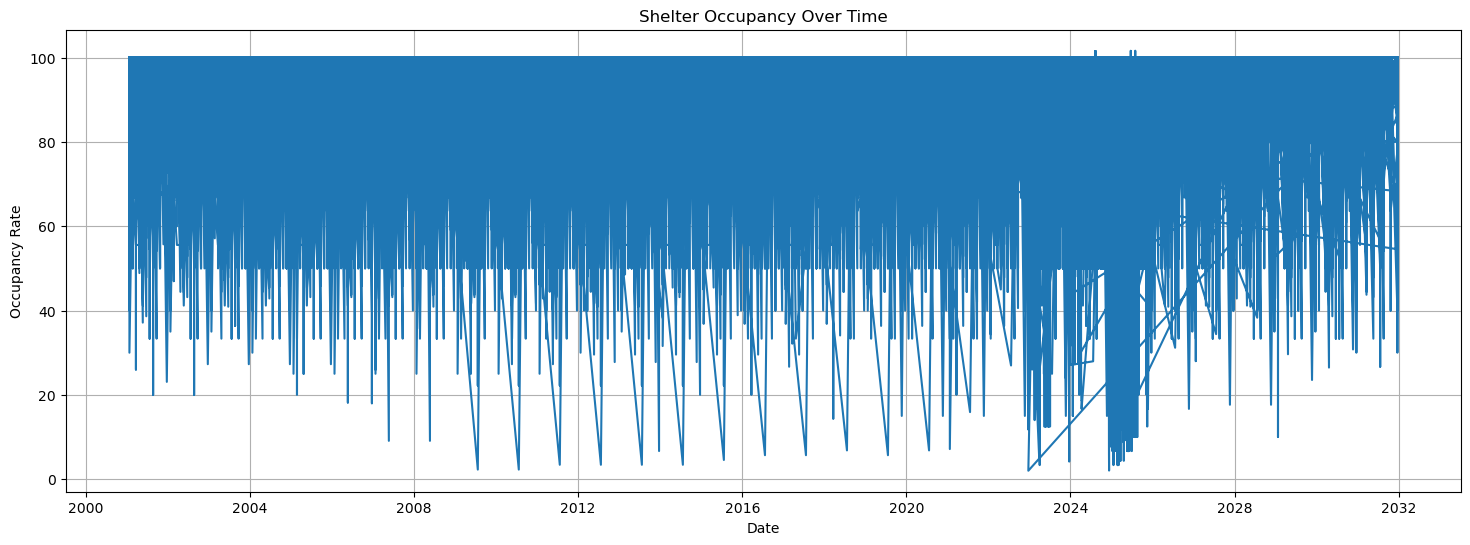

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))

plt.plot(df['OCCUPANCY_DATE'], df['OCCUPANCY_RATE_BEDS'])
plt.title("Shelter Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.grid(True)
plt.show()


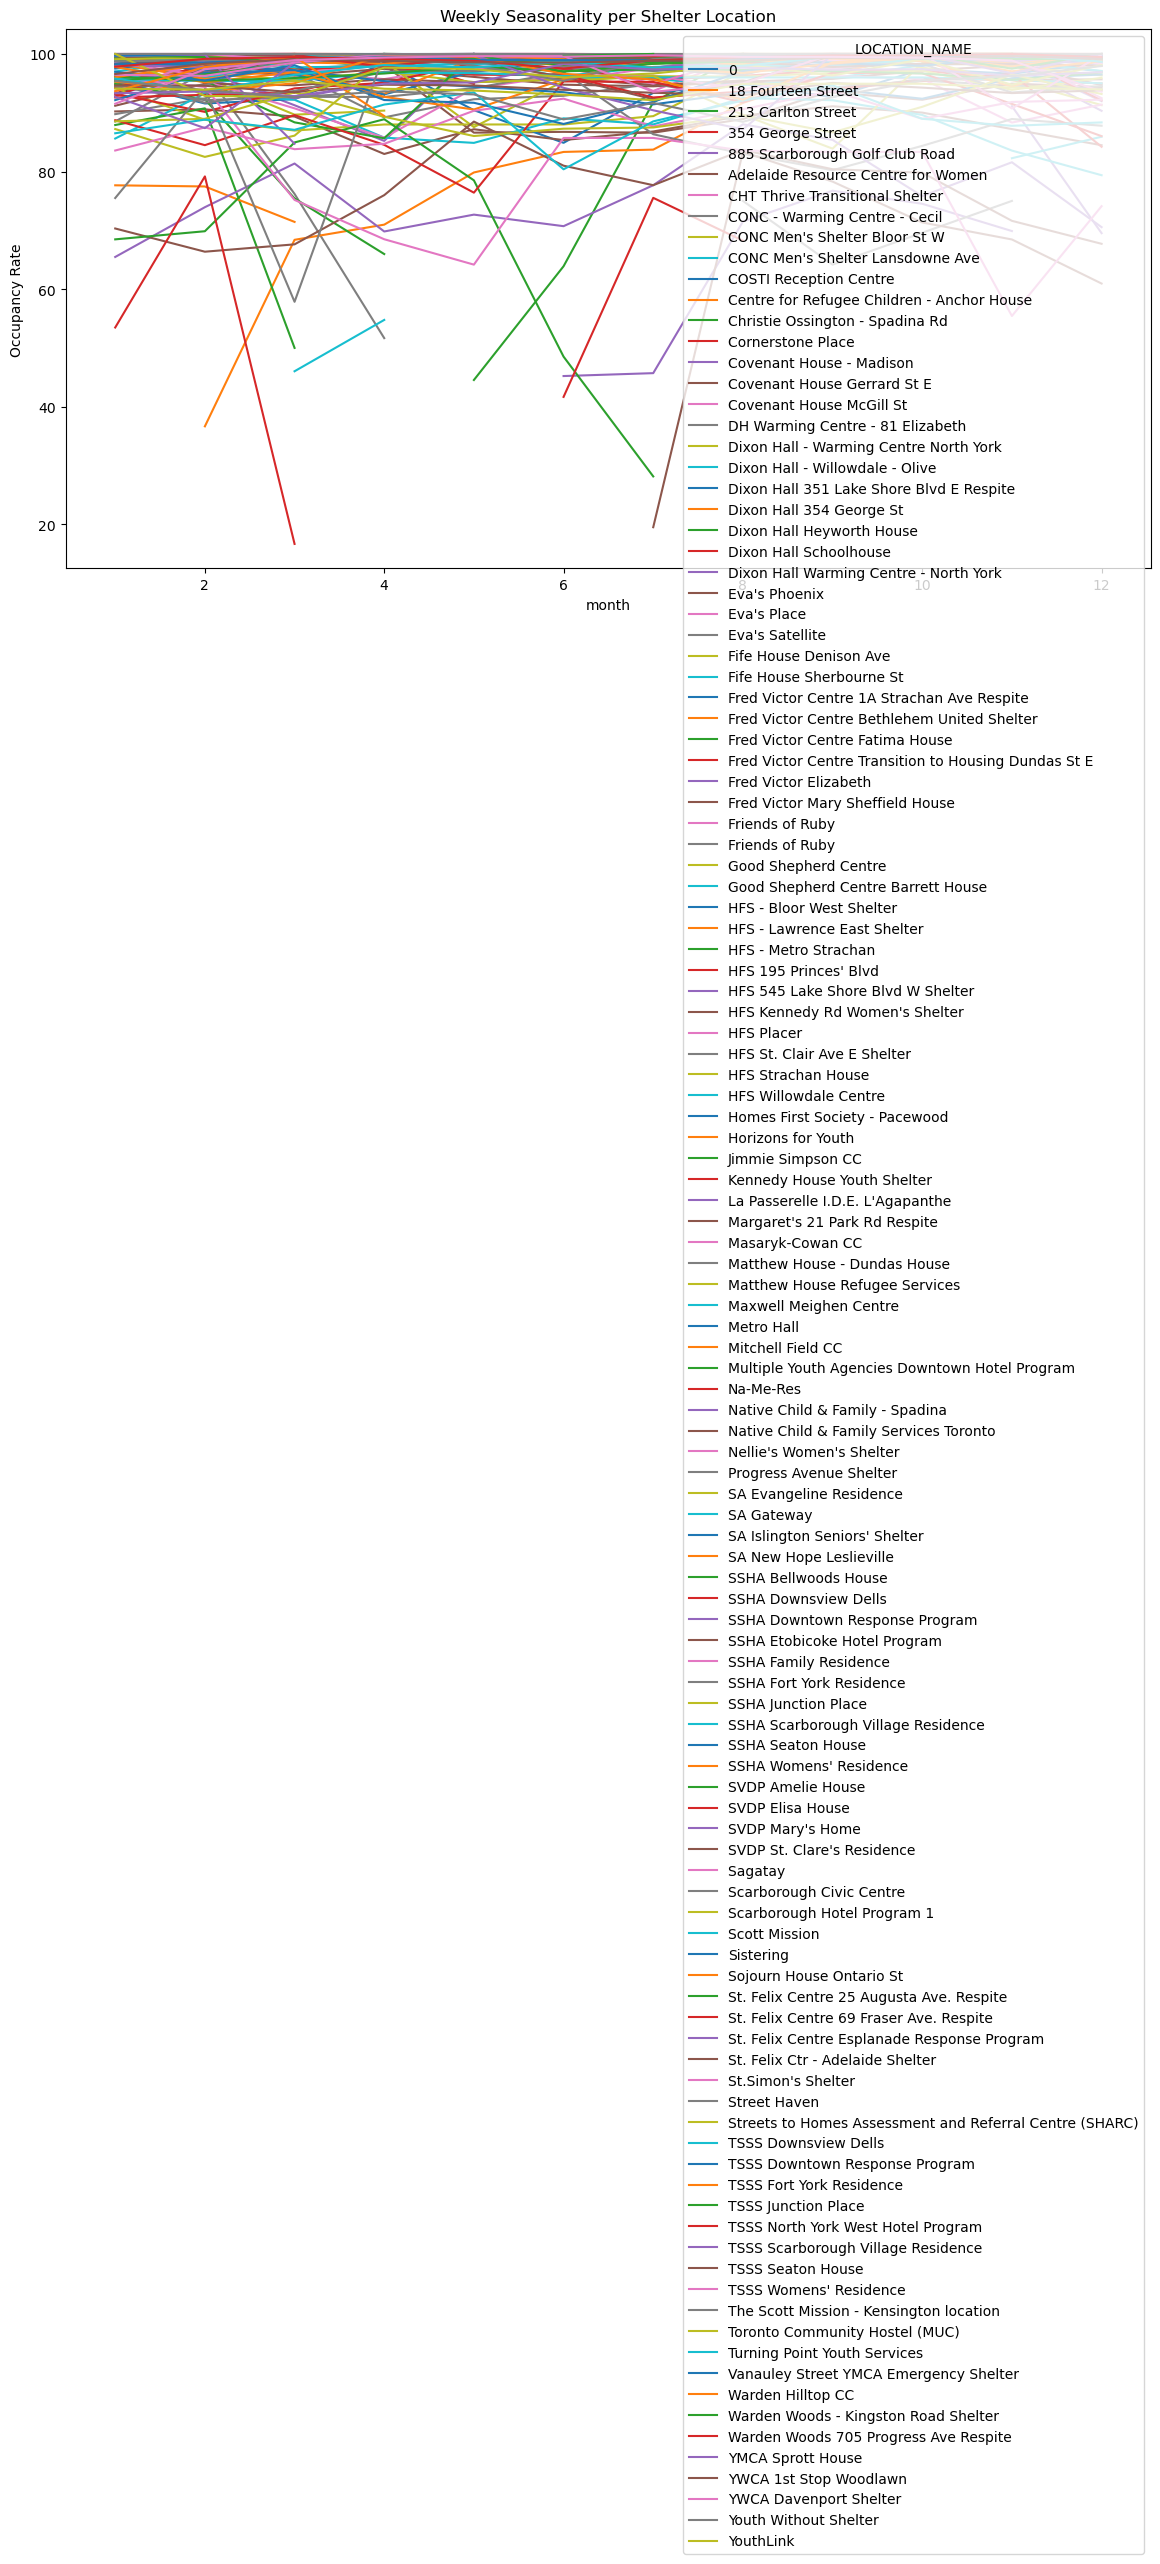

In [22]:
weekly = df.groupby(['LOCATION_NAME', 'month'])['OCCUPANCY_RATE_BEDS'].mean()
weekly.unstack().T.plot(figsize=(14,7))
plt.title("Weekly Seasonality per Shelter Location")
plt.ylabel("Occupancy Rate")
plt.show()



day_of_week averages:
day_of_week
0    96.127503
1    96.117485
2    96.140850
3    96.119165
4    96.166340
5    96.051004
6    96.061440
Name: OCCUPANCY_RATE_BEDS, dtype: float64

Range: 96.0510 to 96.1663
Difference: 0.1153 percentage points


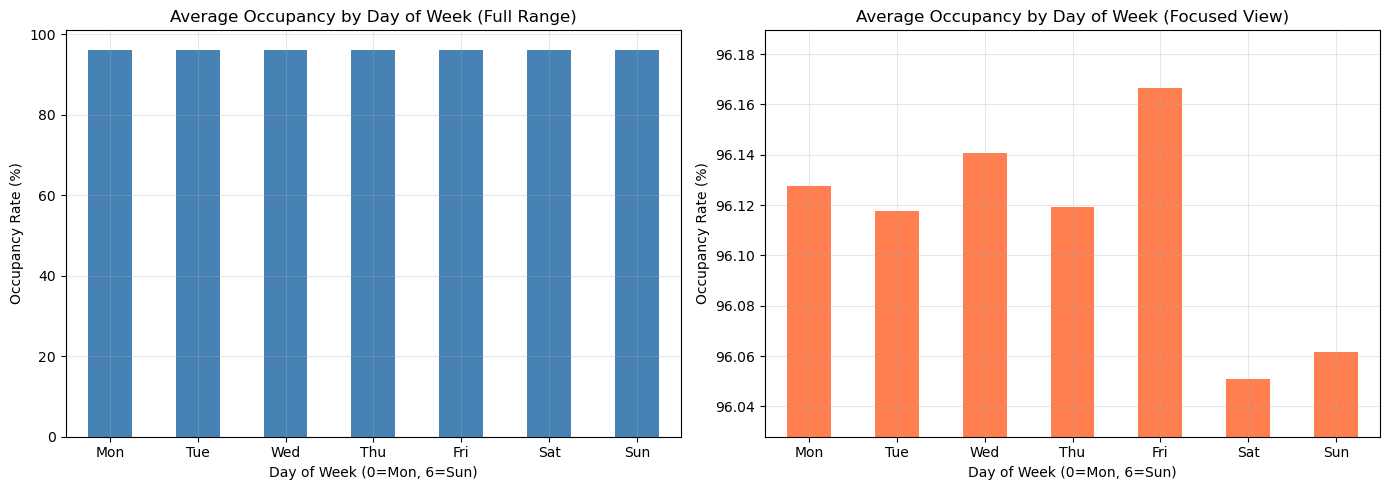

In [ ]:
df['month'] = df['OCCUPANCY_DATE'].dt.month

plt.figure(figsize=(10,5))
df.groupby('month')['OCCUPANCY_RATE_BEDS'].mean().plot(kind='bar')
plt.title("Average Occupancy by Month")
plt.ylabel("Occupancy Rate")
plt.show()


Statistical Test for Day of Week Effect:
F-statistic: 0.4157
P-value: 8.69e-01

No significant difference between days (α=0.05)

Day of Week Statistics:
                  mean        std  count
day_of_week                             
0            96.127503   9.876773  23734
1            96.117485   9.961503  23638
2            96.140850   9.848641  23646
3            96.119165   9.901904  23629
4            96.166340   9.787936  23630
5            96.051004  10.123521  23667
6            96.061440  10.030998  23858


Added cyclical features:
- day_of_week_sin, day_of_week_cos
- month_sin, month_cos
- week_of_year_sin, week_of_year_cos

For ML models: Use cyclical features instead of raw day_of_week/month/week_of_year
This preserves the circular nature of time and helps models learn patterns better.


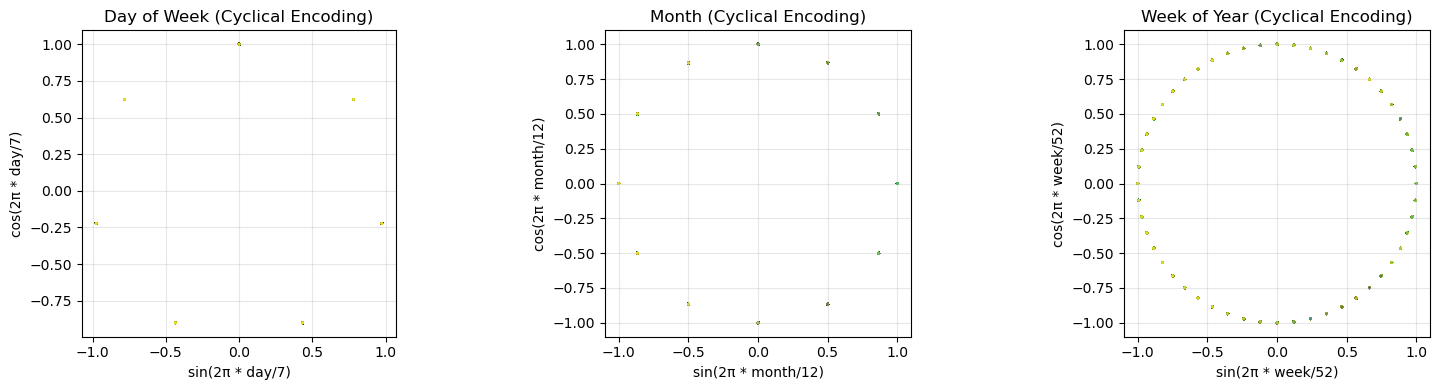

In [28]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Day of week cyclical
ax = axes[0]
ax.scatter(df['day_of_week_sin'], df['day_of_week_cos'], 
           c=df['OCCUPANCY_RATE_BEDS'], cmap='viridis', alpha=0.1, s=1)
ax.set_xlabel('sin(2π * day/7)')
ax.set_ylabel('cos(2π * day/7)')
ax.set_title('Day of Week (Cyclical Encoding)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Month cyclical
ax = axes[1]
ax.scatter(df['month_sin'], df['month_cos'], 
           c=df['OCCUPANCY_RATE_BEDS'], cmap='viridis', alpha=0.1, s=1)
ax.set_xlabel('sin(2π * month/12)')
ax.set_ylabel('cos(2π * month/12)')
ax.set_title('Month (Cyclical Encoding)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Week of year cyclical
ax = axes[2]
ax.scatter(df['week_of_year_sin'], df['week_of_year_cos'], 
           c=df['OCCUPANCY_RATE_BEDS'], cmap='viridis', alpha=0.1, s=1)
ax.set_xlabel('sin(2π * week/52)')
ax.set_ylabel('cos(2π * week/52)')
ax.set_title('Week of Year (Cyclical Encoding)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Key Takeaways for ML Models:

1. **Small differences are still meaningful**: Even 0.1-0.2% differences can be significant with large sample sizes
2. **Use cyclical encoding**: Replace `day_of_week`, `month`, `week_of_year` with their sin/cos pairs
3. **Feature importance**: Tree-based models (RF, XGBoost) can learn from these patterns even if they seem small
4. **Interaction effects**: Day of week might interact with other features (e.g., shelter type, season)
5. **For visualization**: Use focused y-axis ranges to highlight differences


In [29]:
# Example: Prepare features for ML models
# When building your models, use cyclical features instead of raw temporal features

# Features to DROP (use cyclical versions instead):
features_to_drop = ['day_of_week', 'month', 'week_of_year']  # Use sin/cos versions

# Features to INCLUDE:
# - day_of_week_sin, day_of_week_cos
# - month_sin, month_cos  
# - week_of_year_sin, week_of_year_cos
# - lag_1, lag_7, roll_mean_7
# - All your other engineered features

print("For your ML models:")
print("✓ Use cyclical encoding (sin/cos) for temporal features")
print("✓ Small differences (0.1-0.2%) are still learnable by tree-based models")
print("✓ XGBoost and Random Forest can capture these subtle patterns")
print("✓ Consider feature interactions (e.g., day_of_week × shelter_type)")


For your ML models:
✓ Use cyclical encoding (sin/cos) for temporal features
✓ Small differences (0.1-0.2%) are still learnable by tree-based models
✓ XGBoost and Random Forest can capture these subtle patterns
✓ Consider feature interactions (e.g., day_of_week × shelter_type)
